# Batch correction

The **Clinical Knowledge Graph (CKG)** can be used to remove batch effects in the data. CKG uses the library pyComBat (https://github.com/epigenelabs/pyComBat), which uses empirical Bayes frameworks for adjusting data for batch effects. 

Batch effects can arise from pre-analytical conditions such as sampling technique or storage conditions or they can arise during the experimental procedure itself, such as different plates, dates, ms-machine, column or lc.

When an experiment is uploaded to CKG, the batch of each sample can be specified in the experimental design file column: `batch`. At the time of generating the report, you can choose to correct any batch effect by indicating in the configuration args two parameters:

- `batch_correction` (bool): whether or not to run the correction
- `batch_col` (str): what column defines the batch (generally, *batch*)

CKG's analytical pipeline will take these parameters into account and run batch correction accordingly.

Here, we exemplify how to use CKG analytic_core functionality to correct the batch effect from 2 different cohorts of COVID-19 plasma samples that were combined in this [study](https://www.sciencedirect.com/science/article/pii/S2589004221001036?via%3Dihub). The files were downloaded from PRIDE - identifiers: 

- PXD020580
- PXD023016


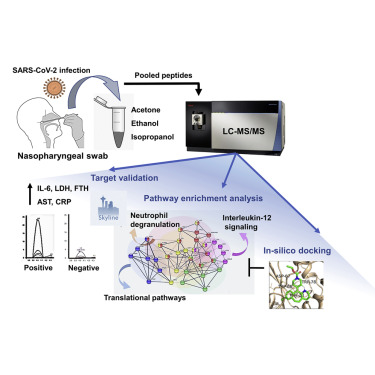



For convenience, files are provided in the tmp folder (tmp/batch_correction) together with a generated experimental design file with what we could extract from the metadata. There can be differences with the actual study due to mapping issues but it is a good example of how batch effect is corrected in CKG.

To upload these files in CKG:

1) Create a new project
2) In the Data upload page, upload the experimental design (contains all the samples) and one of the proteomics files (i.e PXD020580) 
3) Once these files are uploaded, upload the second proteomics file (i.e PXD023016).


To visualize in a PCA how the batch effect correction is removed from the proceesed dataset, you can add in the analysis configuration a section like this:

```yaml
uncorrected_pca_batch:
    data: uncorrected_batch
    analyses:
        - pca
    plots:
        - pca
    args:
        hovering_cols:
            - sample
        drop_cols:
            - sample
            - subject
            - group
        group: batch
        x_title: PC1
        y_title: PC2
        components: 2
        init: 'pca'
        width: 1000
        height: 700
        loadings: 15
        factor: 50
        title: 'Sample stratification with PCA - uncorrected batch effect - Batch'
```

### Notebook

In this notebook, we will load the original dataset from the uploaded project and follow the processing and batch effect correction steps.

In [1]:
import os
import pandas as pd

import ckg.ckg_utils as ckg_utils
from ckg.graphdb_builder import builder_utils
from ckg.graphdb_builder.experiments.parsers import proteomicsParser

from ckg.report_manager import project
from ckg.analytics_core.analytics import analytics 
from ckg.analytics_core.viz import viz

from plotly.offline import init_notebook_mode, iplot
%matplotlib inline
init_notebook_mode(connected=True)

c:\users\sande\.conda\envs\pip_rev\lib\site-packages\outdated\utils.py:18: OutdatedPackageWarning:

The package pingouin is out of date. Your version is 0.3.11, the latest is 0.3.12.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.



WGCNA functions will not work. Module Rpy2 not installed.
R functions will not work. Module Rpy2 not installed.


# The results from the CKG app can be visualized and further analyzed here

In [14]:
p = project.Project(identifier='P0000017', configuration_files={}, datasets={}, knowledge=None, report={})

In [15]:
p.build_project(force=False)
p.generate_report()

In [16]:
original_data = p.get_dataset("proteomics").get_dataframe("original")

In [17]:
original_data.head()

,LFQ_intensity,batch,group,identifier,name,sample,subject
0,24.032210,2,Negative,P04217,A1BG,39pool,PXD020580_68
1,22.818177,2,Negative,P04217,A1BG,173_pool,PXD020580_11
2,21.312409,2,Negative,P04217,A1BG,11_pool,PXD020580_37
3,22.561322,2,Negative,P04217,A1BG,30_pool,PXD020580_18
4,23.135537,2,Negative,P04217,A1BG,198_pool,PXD020580_165


In [18]:
processed_data = analytics.get_proteomics_measurements_ready(original_data,
                                                              index_cols=['group', 'sample', 'subject', 'batch'],
                                                              drop_cols=[],
                                                              group='group',
                                                              identifier='identifier',
                                                              extra_identifier='name',
                                                              filter_samples=False,
                                                              imputation=True,
                                                              imputation_method='distribution',
                                                              missing_method='percentage',
                                                              missing_per_group=True,
                                                              missing_max=0.5,
                                                              value_col='LFQ_intensity',
                                                              shift=1.8,
                                                              nstd=0.3)

In [19]:
processed_data.head()

identifier,group,sample,subject,batch,A1BG~P04217,A2M~P01023,AARS1~P49588,ABHD12B~Q7Z5M8,ACBD3~Q9H3P7,ACO2~Q99798,...,XRCC5~P13010,XRCC6~P12956,YBX1~P67809,YWHAB~P31946,YWHAE~P62258,YWHAG~P61981,YWHAH~Q04917,YWHAQ~P27348,YWHAZ~P63104,ZG16B~Q96DA0
0,Negative,11_pool,PXD020580_37,2,21.312409,26.548911,20.405800,20.855230,21.046427,23.970005,...,20.459354,19.064410,19.861664,22.851252,18.866241,20.314623,21.532212,18.000125,20.192224,26.406718
1,Negative,12_pool,PXD020580_38,2,18.947086,20.850335,18.897968,20.118419,23.031672,20.386911,...,19.522988,20.895987,19.656218,19.898359,22.884871,19.358429,17.088187,19.988028,25.780417,27.887858
2,Negative,13_pool,PXD020580_39,2,18.930766,19.620407,22.170997,19.579852,22.880057,17.551108,...,17.905797,20.626525,19.705407,20.674868,19.741435,19.140199,19.315568,20.172576,25.787782,27.925526
3,Negative,173_pool,PXD020580_11,2,22.818177,26.481222,22.629387,20.448801,24.477475,27.418765,...,22.193099,23.641741,23.097641,27.678553,29.066149,28.566815,23.855478,28.147635,29.543552,22.736469
4,Negative,175pool,PXD020580_12,2,17.761723,19.701719,19.539977,18.480560,27.456776,18.619836,...,18.825366,20.068438,18.434687,20.849923,20.595838,18.757111,20.322045,19.980570,23.856714,27.073165


## Batch correction

In [20]:
processed_data_corrected = analytics.combat_batch_correction(data=processed_data, index_cols=['group','sample','subject'], batch_col = 'batch')

Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data


c:\users\sande\.conda\envs\pip_rev\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



In [21]:
processed_data_corrected.head()

identifier,group,sample,subject,A1BG~P04217,A2M~P01023,AARS1~P49588,ABHD12B~Q7Z5M8,ACBD3~Q9H3P7,ACO2~Q99798,ACOX1~Q15067,...,XRCC5~P13010,XRCC6~P12956,YBX1~P67809,YWHAB~P31946,YWHAE~P62258,YWHAG~P61981,YWHAH~Q04917,YWHAQ~P27348,YWHAZ~P63104,ZG16B~Q96DA0
0,Negative,11_pool,PXD020580_37,22.679424,26.405897,19.993245,24.080817,20.322720,22.965131,22.374179,...,20.097775,18.957149,19.292474,22.088503,18.137226,19.858514,20.978543,17.626513,19.568032,25.653277
1,Negative,12_pool,PXD020580_38,20.108900,20.601108,18.573382,23.253694,22.041474,19.848725,19.299928,...,19.285468,20.596626,19.111939,19.504370,21.697131,19.009884,17.024859,19.434463,24.727817,27.114564
2,Negative,13_pool,PXD020580_39,20.091164,19.348256,21.655458,22.649113,21.910212,17.382279,18.254541,...,17.882538,20.355426,19.155163,20.183908,18.912517,18.816204,19.006477,19.602306,24.734618,27.151727
3,Negative,173_pool,PXD020580_11,24.315824,26.336947,22.087105,23.624571,23.293200,25.964700,20.581386,...,21.601817,23.054399,22.136081,26.312967,27.172820,27.182400,23.045467,26.855436,28.202459,22.032220
4,Negative,175pool,PXD020580_12,18.820703,19.431083,19.177935,21.415079,25.872574,18.311807,23.261753,...,18.680274,19.855873,18.038521,20.337102,19.669390,18.476210,19.901902,19.427681,22.951590,26.310791


### PCA with Uncorrected Data

As it can be seen, the PCA plot shows clear "batch effect" separating both proteomics experiments (batch 1: PXD023016, batch 2: PXD020580).

In [22]:
r, nargs = analytics.run_pca(data = processed_data, drop_cols=['sample', 'subject', 'group'], group='batch', annotation_cols=['sample'], components=2, dropna=True)
plot = viz.get_pca_plot(r, identifier='pca', args=nargs)#{'loadings':15, 'title':'PCA Plot', 'x_title':'PC1', 'y_title':'PC2', 'group':'group','height':900, 'width':900})
iplot(plot.figure)

In [24]:
r, nargs = analytics.run_pca(data = processed_data, drop_cols=['sample', 'subject', 'batch'], group='group', annotation_cols=['sample', 'batch'], components=2, dropna=True)
plot = viz.get_pca_plot(r, identifier='pca', args=nargs)#{'loadings':15, 'title':'PCA Plot', 'x_title':'PC1', 'y_title':'PC2', 'group':'group','height':900, 'width':900})
iplot(plot.figure)

### PCA with Corrected Data 

The PCA shows that both experiments are now integrated and the batch effect is removed.

In [23]:
r, nargs = analytics.run_pca(data = processed_data_corrected, drop_cols=['sample', 'subject'], group='group', annotation_cols=['sample'], components=2, dropna=True)
plot = viz.get_pca_plot(r, identifier='pca', args=nargs)#{'loadings':15, 'title':'PCA Plot', 'x_title':'PC1', 'y_title':'PC2', 'group':'group','height':900, 'width':900})
iplot(plot.figure)